# AUDIO CLASSIFICATION USING CNN </BR> TEAM ENSEMBLE </BR> 1. SHIVAM KUMAR</BR> 2. MITANSHU CHAKRAWARTY
## ABSTRACT: https://docs.google.com/document/d/1ZuANeFxBhUZMn2YhAssWtF9ALVaMNd1GFn1Toyv46TA/edit#

# AUDIO PREPROCESSING - CONVERTING TO SPECTROGRAM IMAGES

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment
import pandas as pd
from tqdm import tqdm
import numpy  as np
import scipy.signal
import os

aud_dir = os.listdir("/kaggle/input/mosaic-dataset/Mosaic23_PS1_TrainData/ICBHI_final_database/")
aud_list = [aud for aud in aud_dir if aud.endswith(".wav")]
audios = []
crackles = []
wheezes = []
main_df = pd.DataFrame({"slices":[], "W":[], "C":[]})
for k in tqdm(aud_list):
    audio_file, sr = librosa.load("/kaggle/input/mosaic-dataset/Mosaic23_PS1_TrainData/ICBHI_final_database/"+ k, sr = 44000)
    audio_data = np.array(audio_file)
    df = pd.read_csv(f"/kaggle/input/mosaic-dataset/Mosaic23_PS1_TrainData/ICBHI_final_database/{k[:-4]}.txt", sep = "\t", header = None)
    crackles.append(np.array(df[2]))
    wheezes.append(np.array(df[3]))
    slices = []
    for i in (range(0,len(df))):
        start_time = df[0][i]
        end_time = df[1][i]
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        sliced_audio_data = audio_data[start_sample:end_sample]
        resampled_audio_file = scipy.signal.resample(sliced_audio_data, 44000)

        melspec = librosa.feature.melspectrogram(y = resampled_audio_file, sr=44000, n_mels = 128)
        melspec = librosa.power_to_db(melspec).astype(np.float32)
        slices.append(melspec)
    slice_df = pd.DataFrame({"slices":slices, "W":np.array(df[3]), "C":np.array(df[2]) })
    main_df = pd.concat([main_df, slice_df])
    slices = np.array(slices)
    audios.append(slices)

100%|██████████| 810/810 [04:33<00:00,  2.96it/s]


In [2]:
main_df.reset_index(inplace=True)
main_df.drop("index", axis = 1, inplace = True)
main_df

,slices,W,C
0,"[[30.372871, 32.512085, 26.11124, 29.012907, 3...",0.0,0.0
1,"[[16.49701, 21.928442, 19.824705, 20.381557, 2...",1.0,1.0
2,"[[0.6617675, 10.186587, 19.026583, 19.510904, ...",0.0,0.0
3,"[[24.888401, 25.250214, 29.764576, 31.796854, ...",1.0,0.0
4,"[[26.604013, 29.365238, 27.252333, 24.023802, ...",1.0,0.0
...,...,...,...
6105,"[[0.5466974, 5.086958, 10.526192, 8.43177, 11....",0.0,1.0
6106,"[[5.769548, 4.2293057, -1.2950494, 9.626252, 1...",0.0,1.0
6107,"[[14.708195, 25.172918, 30.015781, 27.422512, ...",0.0,1.0
6108,"[[17.315462, 25.967009, 26.21937, 20.873978, 1...",0.0,1.0


In [3]:
main_df["Labels"] = np.zeros((6110,))
for i in range(0, len(main_df)):
    if main_df["C"][i] == 0 and main_df["W"][i] == 0:
        main_df["Labels"][i] = "Healthy"
    elif main_df["C"][i] == 0 and main_df["W"][i] == 1:
        main_df["Labels"][i] = "Wheezes"
    elif main_df["C"][i] == 1 and main_df["W"][i] == 0:
        main_df["Labels"][i] = "Crackles"
    elif main_df["C"][i] == 1 and main_df["W"][i] == 1:
        main_df["Labels"][i] = "Both"

main_df.drop(["W", "C"], axis = 1, inplace = True)
main_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,slices,Labels
0,"[[30.372871, 32.512085, 26.11124, 29.012907, 3...",Healthy
1,"[[16.49701, 21.928442, 19.824705, 20.381557, 2...",Both
2,"[[0.6617675, 10.186587, 19.026583, 19.510904, ...",Healthy
3,"[[24.888401, 25.250214, 29.764576, 31.796854, ...",Wheezes
4,"[[26.604013, 29.365238, 27.252333, 24.023802, ...",Wheezes
...,...,...
6105,"[[0.5466974, 5.086958, 10.526192, 8.43177, 11....",Crackles
6106,"[[5.769548, 4.2293057, -1.2950494, 9.626252, 1...",Crackles
6107,"[[14.708195, 25.172918, 30.015781, 27.422512, ...",Crackles
6108,"[[17.315462, 25.967009, 26.21937, 20.873978, 1...",Crackles


In [4]:
main_df["Labels"].value_counts() # CLASS IMBALANCE

Healthy     3168
Crackles    1712
Wheezes      768
Both         462
Name: Labels, dtype: int64

In [5]:
x = audios[0]
for i in tqdm(range(1, len(audios))):
    x = np.concatenate([x, audios[i]])
x.shape

100%|██████████| 809/809 [00:41<00:00, 19.52it/s] 


(6110, 128, 86)

## PERFORMING OVER SAMPLING TO TACKLE CLASS IMBALANCE

In [6]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

X = x.copy()
X_flat = np.reshape(X, (X.shape[0], -1))
y = np.array(main_df["Labels"])
smote = SMOTE()
xresampled, yresampled = smote.fit_resample(X_flat, y)
xresampled.shape, yresampled.shape

((12672, 11008), (12672,))

In [8]:
xreshaped = np.reshape(xresampled, (12672,128,86))
xreshaped.shape

(12672, 128, 86)

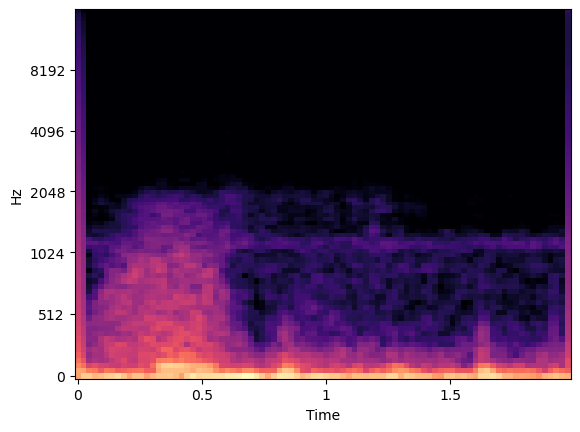

In [78]:
librosa.display.specshow(xreshaped[4900],
                         y_axis='mel', fmax=16000, x_axis='time')

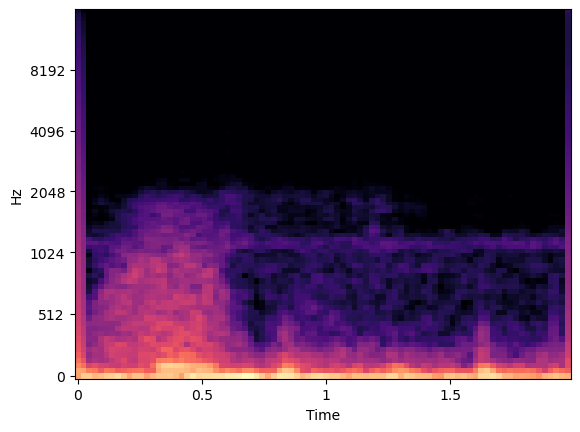

In [79]:
librosa.display.specshow(x[4900],
                         y_axis='mel', fmax=16000, x_axis='time')

In [11]:
labeled_df = pd.DataFrame({"Labels":yresampled})
labeled_df

,Labels
0,Healthy
1,Both
2,Healthy
3,Wheezes
4,Wheezes
...,...
12667,Wheezes
12668,Wheezes
12669,Wheezes
12670,Wheezes


In [16]:
labeled_df.value_counts()

Labels  
Both        3168
Crackles    3168
Healthy     3168
Wheezes     3168
dtype: int64

## ONE HOT ENCODING LABELS

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_feature = ["Labels"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer(
[("one_hot", one_hot, categorical_feature)])
transformed_y = transformer.fit_transform(labeled_df)
transformed_y = transformed_y.toarray()
transformed_y

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [13]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xreshaped,transformed_y, test_size = 0.2, random_state=42 )
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((10137, 128, 86), (10137, 4), (2535, 128, 86), (2535, 4))

## DEFINING MODEL ARCHITECTURE

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization

input_shape = (128, 86, 1)

model = tf.keras.models.Sequential([
    Conv2D(filters=32, kernel_size=(3,3),strides=2, input_shape=input_shape,padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters= 32, kernel_size=(3,3),strides=2,padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate=0.20),
    Conv2D(filters= 256, kernel_size=(3,3),strides=2,padding='same'),
    Conv2D(filters= 256, kernel_size=(3,3),strides=2,activation='relu',padding='same'),    
    Dropout(rate=0.20),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(rate=0.20),
    Dense(units=256),
    Dense(units=128),
    Dense(units=32),
    Dense(units=4, activation='softmax'),
    
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 43, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 5, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 3, 256)         7

In [15]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/BestWeights.h5', verbose=1, save_best_only=True)

model.fit(xtrain, ytrain,
            validation_split = 0.2,
            epochs = 40,
            batch_size = 32,
         callbacks = checkpointer)

Epoch 1/40


2023-03-21 18:25:27.367915: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


254/254 [==============================] - ETA: 0s - loss: 1.8435 - accuracy: 0.2891
Epoch 1: val_loss improved from inf to 1.28535, saving model to /kaggle/working/BestWeights.h5
254/254 [==============================] - 15s 12ms/step - loss: 1.8435 - accuracy: 0.2891 - val_loss: 1.2854 - val_accuracy: 0.4142
Epoch 2/40
254/254 [==============================] - ETA: 0s - loss: 1.3547 - accuracy: 0.3312
Epoch 2: val_loss did not improve from 1.28535
254/254 [==============================] - 2s 8ms/step - loss: 1.3547 - accuracy: 0.3312 - val_loss: 1.3180 - val_accuracy: 0.3989
Epoch 3/40
253/254 [============================>.] - ETA: 0s - loss: 1.2717 - accuracy: 0.4058
Epoch 3: val_loss improved from 1.28535 to 1.20439, saving model to /kaggle/working/BestWeights.h5
254/254 [==============================] - 2s 9ms/step - loss: 1.2716 - accuracy: 0.4058 - val_loss: 1.2044 - val_accuracy: 0.4763
Epoch 4/40
248/254 [============================>.] - ETA: 0s - loss: 1.2078 - accuracy

## LOADING BEST WEIGHTS 

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization

input_shape = (128, 86, 1)

loaded_model = tf.keras.models.Sequential([
    Conv2D(filters=32, kernel_size=(3,3),strides=2, input_shape=input_shape,padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters= 32, kernel_size=(3,3),strides=2,padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate=0.20),
    Conv2D(filters= 256, kernel_size=(3,3),strides=2,padding='same'),
    Conv2D(filters= 256, kernel_size=(3,3),strides=2,activation='relu',padding='same'),    
    Dropout(rate=0.20),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(rate=0.20),
    Dense(units=256),
    Dense(units=128),
    Dense(units=32),
    Dense(units=4, activation='softmax'),
    
])
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

loaded_model.load_weights("/kaggle/working/BestWeights.h5")

## MAKING PREDICTIONS ON TEST SET

In [26]:
pred = loaded_model.predict(xtest)
pred.shape

80/80 [==============================] - 0s 3ms/step


(2535, 4)

In [27]:
def convert_to_one_hot(prob_arrays):
    one_hot_arrays = []
    for prob_array in prob_arrays:
        max_index = prob_array.argmax()
        one_hot_array = [1 if i == max_index else 0 for i in range(len(prob_array))]
        one_hot_arrays.append(one_hot_array)
    return np.array(one_hot_arrays)

ypreds = convert_to_one_hot(pred)

In [28]:
def label(arr):
    arr=np.array(arr)
    list2=[]
    for i in range(0,len(arr)):
        list2.append((arr[i]).argmax())
    return list2

labeled_pred = label(ypreds)

In [29]:
labeled_y = label(ytest)

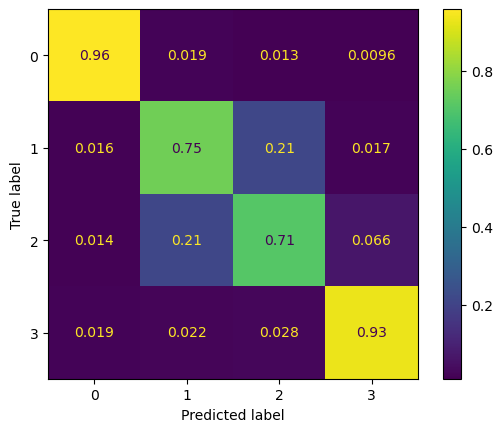

In [30]:
from sklearn.metrics import plot_confusion_matrix,ConfusionMatrixDisplay, confusion_matrix
cm=confusion_matrix(labeled_y,labeled_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [31]:
from sklearn.metrics import classification_report
rep = (pd.DataFrame(classification_report(labeled_y,labeled_pred,output_dict=True)))
rep

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.950794,0.746855,0.738134,0.910334,0.83787,0.836529,0.836411
recall,0.958400,0.753968,0.708006,0.931571,0.83787,0.837986,0.837870
f1-score,0.954582,0.750395,0.722756,0.920830,0.83787,0.837141,0.837022
support,625.000000,630.000000,637.000000,643.000000,0.83787,2535.000000,2535.000000
